In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import plotly
import torch
import gpytorch

In [2]:
uv_eg = weekday_time_series(sensor_id='uv_eg_30T')

In [ ]:
uv_eg['kw'] = round(uv_eg['kw'], 2)

In [ ]:
px.line(
    x=uv_eg.index, y=uv_eg.kw, 
    title='entsorgung_5T',
    labels={
        'x': 'Time',
        'y': 'kW'
    },
    markers=False)

In [ ]:
uv_eg.index.shape

(240,)

In [10]:
time_int_range = np.arange(0, 240*5, 5)
uv_eg['t'] = time_int_range

#entsorgung_final = pd.DataFrame(data=entsorgung['kw'], index=entsorgung['t'])
#entsorgung_final.reset_index(inplace=True)

X = uv_eg['t'].values
y = uv_eg['kw'].values
n = len(X)
prop_train = 0.8
n_train = round(prop_train * n)

# Training
X_train = torch.from_numpy(X[:n_train]).to(torch.float64)
y_train = torch.from_numpy(y[:n_train]).to(torch.float64)

# Testing
#X_test = torch.from_numpy(y[n_train:]).to(torch.float64)
X_test = torch.from_numpy(X).to(torch.float64)
y_test = torch.from_numpy(y[n_train:]).to(torch.float64)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

plt.figure(figsize=(16, 6))
#plt.plot(X_train.numpy(), y_train.numpy())
#plt.plot(X_test.numpy(), y_test.numpy())

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

In [78]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(110, 130) ## short term

        seasonal_periodic_short = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_short
        )

        period_constraint_long = gpytorch.constraints.Interval(225, 245) ## long term

        seasonal_periodic_long = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_long
        )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.RQKernel()
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [11]:
## v2 - adding scaling parameters ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(110, 130) ## short term

        seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        period_constraint_long = gpytorch.constraints.Interval(225, 245) ## long term

        seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [ ]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 75

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=likelihood, model=model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()

    print('Iter {} , Loss = {} , Noise = {}'.format(
        i+1, loss, model.likelihood.noise.item() 
    ))

    optimizer.step()

model.eval()
likelihood.eval()

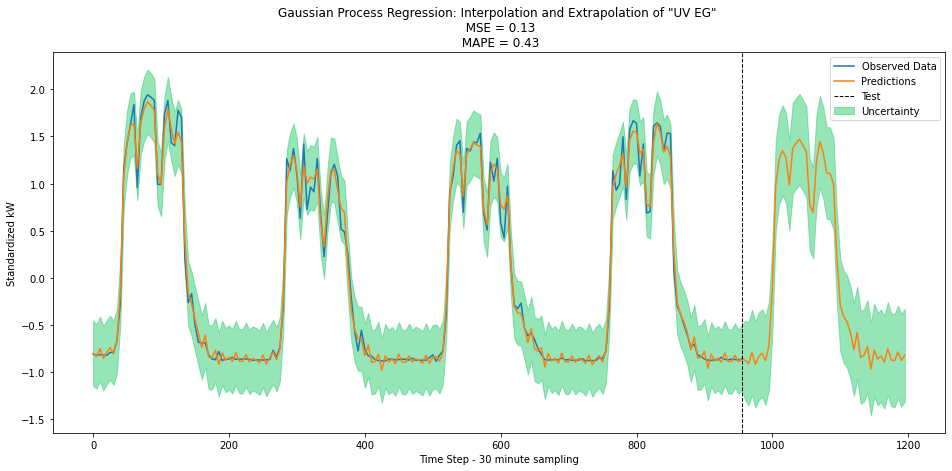

In [27]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_preds = likelihood(model(X_test))

    test_preds = observed_preds.mean[n_train:]
    mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
    mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

    f, ax = plt.subplots(figsize=(16, 7))
    lower, upper = observed_preds.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy())
    ax.plot(X_test.numpy(), observed_preds.mean.numpy())
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    plt.axvline(x=955, linestyle='--', color='black', lw=1)
    ax.legend(['Observed Data', 'Predictions', 'Test', 'Uncertainty'])
    plt.xlabel('Time Step - 30 minute sampling')
    plt.ylabel('Standardized kW')
    plt.title('Gaussian Process Regression: Interpolation and Extrapolation of "UV EG" \n  MSE = {} \n MAPE = {}'.
    format(round(mse, 2), round(mape, 2)))
    plt.show()

In [14]:
test_preds = observed_preds.mean[n_train:]

In [15]:
mean_squared_error(y_test.numpy(), test_preds.numpy()), mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

(0.13356642358096216, 0.4301216585413002)

In [16]:
observed_preds.mean

tensor([-0.8006, -0.8349, -0.7528, -0.8536, -0.7903, -0.7417, -0.7967, -0.6738,
        -0.1526,  1.0762,  1.4372,  1.6169,  1.6359,  1.1610,  1.6462,  1.7919,
         1.8695,  1.8297,  1.7765,  1.1024,  0.9908,  1.5859,  1.7911,  1.5797,
         1.4222,  1.5461,  1.4442,  0.4029, -0.1694, -0.2777, -0.4393, -0.5890,
        -0.7382, -0.6078, -0.8399, -0.8462, -0.7678, -0.9180, -0.7965, -0.8745,
        -0.8453, -0.8879, -0.7961, -0.8850, -0.8868, -0.8153, -0.8910, -0.8569,
        -0.8726, -0.9022, -0.8191, -0.9161, -0.8479, -0.7855, -0.8665, -0.7543,
        -0.2198,  1.0114,  1.1983,  1.2984,  1.1353,  0.7509,  1.1930,  1.0067,
         1.0683,  1.0497,  1.1544,  0.5870,  0.3307,  0.8218,  1.1465,  1.1401,
         0.9324,  0.7405,  0.6934,  0.1363, -0.3340, -0.5475, -0.6465, -0.6447,
        -0.8255, -0.7120, -0.8977, -0.8869, -0.8093, -0.9828, -0.8282, -0.8940,
        -0.8630, -0.9126, -0.8107, -0.8951, -0.8969, -0.8279, -0.8935, -0.8602,
        -0.8798, -0.9082, -0.8216, -0.90